In [ ]:
!pip -q install networkx flask

import math
import json
import time
import random
import hashlib
from dataclasses import dataclass, field
from typing import Dict, Any, List, Tuple, Optional

import networkx as nx
from flask import Flask, request, jsonify

import matplotlib.pyplot as plt


def _sigmoid(x: float) -> float:
    return 1.0 / (1.0 + math.exp(-x))

def _clamp(x: float, lo: float = 0.0, hi: float = 1.0) -> float:
    return max(lo, min(hi, x))

def _now_ts() -> float:
    return time.time()

def _stable_hash(s: str) -> int:
    h = hashlib.sha256(s.encode("utf-8")).hexdigest()
    return int(h[:10], 16)

def _rand_choice_weighted(items: List[Any], weights: List[float]) -> Any:
    return random.choices(items, weights=weights, k=1)[0]

def _pretty(obj: Any) -> str:
    return json.dumps(obj, indent=2, sort_keys=False)

In [ ]:
ZONES = ["public", "dmz", "app", "data", "admin"]
SENSITIVITY = {"public": 0.15, "dmz": 0.35, "app": 0.6, "data": 0.85, "admin": 0.95}

ASSETS = {
    "public": ["cdn", "landing", "status"],
    "dmz": ["api_gateway", "waf", "vpn"],
    "app": ["orders_svc", "billing_svc", "ml_inference", "inventory_svc"],
    "data": ["customer_db", "ledger_db", "feature_store"],
    "admin": ["iam", "siem", "backup_vault"]
}

ACTIONS = ["read", "write", "deploy", "admin", "exfiltrate"]

ROLES = ["customer", "employee", "analyst", "engineer", "admin", "secops"]

DEVICE_TYPES = ["managed_laptop", "managed_server", "byod_phone", "unknown_iot"]
NETWORK_CONTEXT = ["corp_lan", "corp_vpn", "public_wifi", "tor_exit"]

@dataclass
class RequestContext:
    user: str
    role: str
    device_id: str
    device_type: str
    device_posture: float
    mfa: bool
    source: str
    src_node: str
    dst_node: str
    action: str
    time_bucket: str
    geo_risk: float
    behavior_anomaly: float
    data_volume: float
    reason: str = ""

@dataclass
class Decision:
    allowed: bool
    trust_score: float
    rule_hits: List[str] = field(default_factory=list)
    controls: Dict[str, Any] = field(default_factory=dict)
    explanation: str = ""
    ts: float = field(default_factory=_now_ts)

@dataclass
class PrincipalState:
    user: str
    role: str
    base_risk: float
    last_seen_ts: float
    rolling_denies: int = 0
    rolling_allows: int = 0
    quarantined: bool = False
    compromise_score: float = 0.0

@dataclass
class DeviceState:
    device_id: str
    device_type: str
    owner: str
    posture: float
    attested: bool
    quarantined: bool = False

@dataclass
class FlowRecord:
    ts: float
    ctx: Dict[str, Any]
    decision: Dict[str, Any]

In [ ]:
def build_microsegmented_graph(seed: int = 7) -> nx.DiGraph:
    random.seed(seed)
    G = nx.DiGraph()

    for z in ZONES:
        G.add_node(f"zone:{z}", kind="zone", zone=z, sensitivity=SENSITIVITY[z])

    for z, assets in ASSETS.items():
        for a in assets:
            node = f"{z}:{a}"
            G.add_node(node, kind="asset", zone=z, sensitivity=SENSITIVITY[z] + random.uniform(-0.05, 0.05))
            G.add_edge(f"zone:{z}", node, kind="contains")

    allowed_paths = [
        ("public", "dmz"),
        ("dmz", "app"),
        ("app", "data"),
        ("admin", "app"),
        ("admin", "data"),
        ("admin", "dmz"),
        ("dmz", "admin")
    ]

    for src_z, dst_z in allowed_paths:
        G.add_edge(f"zone:{src_z}", f"zone:{dst_z}", kind="zone_route", base_allowed=True)

    for src_z, dst_z in allowed_paths:
        for src_a in ASSETS[src_z]:
            for dst_a in ASSETS[dst_z]:
                if random.random() < 0.45:
                    G.add_edge(f"{src_z}:{src_a}", f"{dst_z}:{dst_a}", kind="service_call", base_allowed=True)

    for z in ZONES:
        for a in ASSETS[z]:
            if random.random() < 0.35:
                G.add_edge(f"{z}:{a}", f"{z}:{a}", kind="self", base_allowed=True)

    return G

def draw_graph(G: nx.DiGraph, title: str = "Zero-Trust Microsegmented Network Graph") -> None:
    plt.figure(figsize=(14, 9))
    pos = nx.spring_layout(G, seed=42, k=0.35)
    kinds = nx.get_node_attributes(G, "kind")
    node_colors = []
    for n in G.nodes():
        if kinds.get(n) == "zone":
            node_colors.append(0.85)
        else:
            node_colors.append(G.nodes[n].get("sensitivity", 0.5))
    nx.draw_networkx_nodes(G, pos, node_size=350, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, arrows=True, alpha=0.25)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [ ]:
class ZeroTrustPolicyEngine:
    def __init__(self, G: nx.DiGraph):
        self.G = G
        self.principals: Dict[str, PrincipalState] = {}
        self.devices: Dict[str, DeviceState] = {}
        self.flow_log: List[FlowRecord] = []
        self.blocked_edges: set = set()
        self.policy_version = "ztpe-v1.3"

        self.role_perms = {
            "customer": {"public": {"read"}, "dmz": {"read"}},
            "employee": {"public": {"read"}, "dmz": {"read"}, "app": {"read", "write"}},
            "analyst": {"public": {"read"}, "dmz": {"read"}, "app": {"read"}, "data": {"read"}},
            "engineer": {"public": {"read"}, "dmz": {"read"}, "app": {"read", "write", "deploy"}, "data": {"read"}},
            "admin": {"public": {"read"}, "dmz": {"read", "write"}, "app": {"read", "write", "deploy", "admin"}, "data": {"read", "write", "admin"}, "admin": {"read", "write", "admin"}},
            "secops": {"public": {"read"}, "dmz": {"read", "write"}, "app": {"read", "admin"}, "data": {"read", "admin"}, "admin": {"read", "admin"}},
        }

        self.w = {
            "role_fit": 1.4,
            "device_posture": 1.8,
            "mfa": 1.0,
            "network_context": 1.2,
            "time": 0.6,
            "geo_risk": 1.2,
            "behavior_anomaly": 2.2,
            "data_volume": 1.4,
            "principal_base_risk": 1.3,
            "principal_compromise": 2.0,
            "asset_sensitivity": 1.6,
            "path_validity": 1.5,
            "quarantine": 4.0,
        }

        self.thresholds = {
            "allow": 0.72,
            "step_up": 0.62,
            "rate_limit": 0.55,
            "deny": 0.0
        }

    def register_principal(self, user: str, role: str, base_risk: float) -> None:
        self.principals[user] = PrincipalState(
            user=user,
            role=role,
            base_risk=_clamp(base_risk),
            last_seen_ts=_now_ts()
        )

    def register_device(self, device_id: str, device_type: str, owner: str, posture: float, attested: bool) -> None:
        self.devices[device_id] = DeviceState(
            device_id=device_id,
            device_type=device_type,
            owner=owner,
            posture=_clamp(posture),
            attested=bool(attested)
        )

    def _asset_zone_and_sensitivity(self, node: str) -> Tuple[str, float]:
        if node.startswith("zone:"):
            z = node.split(":", 1)[1]
            return z, SENSITIVITY.get(z, 0.5)
        z = self.G.nodes[node].get("zone", "public")
        sens = float(self.G.nodes[node].get("sensitivity", SENSITIVITY.get(z, 0.5)))
        return z, _clamp(sens)

    def _base_abac_check(self, role: str, dst_zone: str, action: str) -> bool:
        return action in self.role_perms.get(role, {}).get(dst_zone, set())

    def _path_is_valid(self, src: str, dst: str) -> bool:
        if (src, dst) in self.blocked_edges:
            return False
        try:
            return nx.has_path(self.G, src, dst)
        except nx.NetworkXError:
            return False

    def _network_context_risk(self, source: str) -> float:
        table = {"corp_lan": 0.1, "corp_vpn": 0.25, "public_wifi": 0.65, "tor_exit": 0.9}
        return table.get(source, 0.6)

    def _time_risk(self, time_bucket: str) -> float:
        return 0.15 if time_bucket == "business_hours" else 0.55

    def _compute_trust_score(self, ctx: RequestContext) -> Tuple[float, List[str], Dict[str, Any]]:
        rule_hits = []
        controls: Dict[str, Any] = {}

        principal = self.principals.get(ctx.user)
        device = self.devices.get(ctx.device_id)

        if principal is None:
            rule_hits.append("unknown_principal")
            principal = PrincipalState(ctx.user, ctx.role, base_risk=0.85, last_seen_ts=_now_ts())

        if device is None:
            rule_hits.append("unknown_device")
            device = DeviceState(ctx.device_id, ctx.device_type, owner=ctx.user, posture=0.25, attested=False)

        src_zone, src_sens = self._asset_zone_and_sensitivity(ctx.src_node)
        dst_zone, dst_sens = self._asset_zone_and_sensitivity(ctx.dst_node)

        abac_ok = self._base_abac_check(ctx.role, dst_zone, ctx.action)
        if not abac_ok:
            rule_hits.append("abac_denied")

        path_ok = self._path_is_valid(ctx.src_node, ctx.dst_node)
        if not path_ok:
            rule_hits.append("invalid_path_or_blocked")

        if principal.quarantined or device.quarantined:
            rule_hits.append("quarantined")
            controls["auto_response"] = "deny_quarantine"

        if ctx.action == "exfiltrate":
            rule_hits.append("exfil_attempt")

        if dst_zone in ["admin", "data"] and not ctx.mfa:
            rule_hits.append("mfa_required_for_sensitive_zone")
            controls["step_up_mfa"] = True

        if device.owner != ctx.user:
            rule_hits.append("device_owner_mismatch")

        net_r = self._network_context_risk(ctx.source)
        t_r = self._time_risk(ctx.time_bucket)

        role_fit = 1.0 if abac_ok else 0.0
        posture = _clamp(device.posture if device.attested else device.posture * 0.75)
        mfa = 1.0 if ctx.mfa else 0.0
        path_valid = 1.0 if path_ok else 0.0
        sens = _clamp(dst_sens)

        principal_risk = _clamp(principal.base_risk)
        compromise = _clamp(principal.compromise_score)
        anomaly = _clamp(ctx.behavior_anomaly)
        geo = _clamp(ctx.geo_risk)
        data_vol = _clamp(ctx.data_volume)

        quarantine_penalty = 1.0 if (principal.quarantined or device.quarantined) else 0.0
        owner_mismatch_penalty = 1.0 if (device.owner != ctx.user) else 0.0
        exfil_penalty = 1.0 if (ctx.action == "exfiltrate") else 0.0

        z = 0.0
        z += self.w["role_fit"] * (role_fit - 0.5)
        z += self.w["device_posture"] * (posture - 0.5)
        z += self.w["mfa"] * (mfa - 0.5)
        z += self.w["path_validity"] * (path_valid - 0.5)

        z -= self.w["asset_sensitivity"] * (sens - 0.35)

        z -= self.w["network_context"] * (net_r - 0.25)
        z -= self.w["time"] * (t_r - 0.15)
        z -= self.w["geo_risk"] * (geo - 0.2)

        z -= self.w["behavior_anomaly"] * (anomaly - 0.1)
        z -= self.w["data_volume"] * (data_vol - 0.15)

        z -= self.w["principal_base_risk"] * (principal_risk - 0.2)
        z -= self.w["principal_compromise"] * (compromise - 0.0)

        z -= 2.0 * owner_mismatch_penalty
        z -= 2.5 * exfil_penalty
        z -= self.w["quarantine"] * quarantine_penalty

        trust = _sigmoid(z)

        if trust < self.thresholds["rate_limit"]:
            controls["rate_limit"] = True
        if trust < self.thresholds["step_up"]:
            controls["step_up"] = bool(controls.get("step_up_mfa", False) or dst_zone in ["admin", "data"])
        if trust < self.thresholds["allow"]:
            controls["continuous_auth"] = True

        if "abac_denied" in rule_hits or "invalid_path_or_blocked" in rule_hits or "exfil_attempt" in rule_hits:
            controls["risk_signal"] = "policy_violation"

        if anomaly > 0.75 and sens > 0.75:
            controls["auto_response"] = "quarantine_candidate"

        return _clamp(trust), rule_hits, controls

    def evaluate(self, ctx: RequestContext) -> Decision:
        trust, rule_hits, controls = self._compute_trust_score(ctx)
        allowed = trust >= self.thresholds["allow"]

        if controls.get("step_up"):
            if not ctx.mfa:
                allowed = False
                rule_hits.append("step_up_failed_no_mfa")
            else:
                allowed = allowed or (trust >= self.thresholds["step_up"])

        if controls.get("rate_limit") and trust < 0.5:
            allowed = False
            rule_hits.append("rate_limited_denied")

        explanation = self._explain(ctx, trust, allowed, rule_hits, controls)
        dec = Decision(allowed=allowed, trust_score=trust, rule_hits=rule_hits, controls=controls, explanation=explanation)

        self._post_decision_updates(ctx, dec)

        self.flow_log.append(
            FlowRecord(
                ts=dec.ts,
                ctx=ctx.__dict__.copy(),
                decision={
                    "allowed": dec.allowed,
                    "trust_score": dec.trust_score,
                    "rule_hits": dec.rule_hits,
                    "controls": dec.controls,
                    "explanation": dec.explanation
                }
            )
        )
        return dec

    def _explain(self, ctx: RequestContext, trust: float, allowed: bool, hits: List[str], controls: Dict[str, Any]) -> str:
        src_z, _ = self._asset_zone_and_sensitivity(ctx.src_node)
        dst_z, dst_s = self._asset_zone_and_sensitivity(ctx.dst_node)
        bits = []
        bits.append(f"Decision={'ALLOW' if allowed else 'DENY'} | trust={trust:.3f} | {ctx.user}({ctx.role}) {ctx.action} {ctx.src_node}->{ctx.dst_node}")
        bits.append(f"Context: source={ctx.source}, time={ctx.time_bucket}, geo_risk={ctx.geo_risk:.2f}, anomaly={ctx.behavior_anomaly:.2f}, data_vol={ctx.data_volume:.2f}")
        bits.append(f"Zones: {src_z} -> {dst_z} (dst_sensitivity={dst_s:.2f}) | MFA={'yes' if ctx.mfa else 'no'} | posture={ctx.device_posture:.2f}")
        if hits:
            bits.append(f"Rule hits: {', '.join(hits)}")
        if controls:
            bits.append(f"Controls: {controls}")
        return " | ".join(bits)

    def _post_decision_updates(self, ctx: RequestContext, dec: Decision) -> None:
        p = self.principals.get(ctx.user)
        d = self.devices.get(ctx.device_id)

        if p is None:
            self.register_principal(ctx.user, ctx.role, base_risk=0.65)
            p = self.principals[ctx.user]
        if d is None:
            self.register_device(ctx.device_id, ctx.device_type, ctx.user, ctx.device_posture, attested=(ctx.device_type.startswith("managed")))
            d = self.devices[ctx.device_id]

        p.last_seen_ts = dec.ts

        if dec.allowed:
            p.rolling_allows += 1
            p.rolling_denies = max(0, p.rolling_denies - 1)
            p.compromise_score = _clamp(p.compromise_score - 0.02)
        else:
            p.rolling_denies += 1
            p.compromise_score = _clamp(p.compromise_score + 0.06 + 0.10 * (1.0 if "exfil_attempt" in dec.rule_hits else 0.0))

        if dec.controls.get("auto_response") == "quarantine_candidate" or p.rolling_denies >= 4 or p.compromise_score > 0.78:
            p.quarantined = True
            if d:
                d.quarantined = True

        if ("invalid_path_or_blocked" in dec.rule_hits) or ("exfil_attempt" in dec.rule_hits) or ("abac_denied" in dec.rule_hits):
            self.blocked_edges.add((ctx.src_node, ctx.dst_node))

    def stats(self) -> Dict[str, Any]:
        total = len(self.flow_log)
        allows = sum(1 for r in self.flow_log if r.decision["allowed"])
        denies = total - allows
        top_denies = {}
        for r in self.flow_log:
            if not r.decision["allowed"]:
                for h in r.decision["rule_hits"]:
                    top_denies[h] = top_denies.get(h, 0) + 1
        principals = {
            u: {
                "role": p.role,
                "base_risk": round(p.base_risk, 3),
                "compromise_score": round(p.compromise_score, 3),
                "rolling_denies": p.rolling_denies,
                "rolling_allows": p.rolling_allows,
                "quarantined": p.quarantined
            }
            for u, p in self.principals.items()
        }
        devices = {
            did: {
                "owner": d.owner,
                "type": d.device_type,
                "posture": round(d.posture, 3),
                "attested": d.attested,
                "quarantined": d.quarantined
            }
            for did, d in self.devices.items()
        }
        return {
            "policy_version": self.policy_version,
            "flows_total": total,
            "flows_allow": allows,
            "flows_deny": denies,
            "deny_reasons_top": dict(sorted(top_denies.items(), key=lambda kv: kv[1], reverse=True)[:10]),
            "blocked_edges_count": len(self.blocked_edges),
            "principals": principals,
            "devices": devices
        }

In [ ]:
def make_world(engine: ZeroTrustPolicyEngine, seed: int = 13) -> Dict[str, Any]:
    random.seed(seed)

    users = [
        ("alice", "employee", 0.18),
        ("bob", "engineer", 0.22),
        ("cathy", "analyst", 0.25),
        ("dan", "admin", 0.15),
        ("eve", "secops", 0.10),
        ("mallory", "employee", 0.55)
    ]
    for u, r, br in users:
        engine.register_principal(u, r, br)

    devices = [
        ("dev-alice-lt", "managed_laptop", "alice", 0.82, True),
        ("dev-bob-lt", "managed_laptop", "bob", 0.77, True),
        ("dev-cathy-lt", "managed_laptop", "cathy", 0.74, True),
        ("dev-dan-lt", "managed_laptop", "dan", 0.88, True),
        ("dev-eve-lt", "managed_laptop", "eve", 0.90, True),
        ("dev-mallory-byod", "byod_phone", "mallory", 0.42, False),
        ("unknown-iot-7", "unknown_iot", "unknown", 0.20, False),
    ]
    for did, dt, owner, posture, attested in devices:
        engine.register_device(did, dt, owner, posture, attested)

    all_assets = [n for n in engine.G.nodes() if engine.G.nodes[n].get("kind") == "asset"]
    by_zone = {z: [a for a in all_assets if engine.G.nodes[a].get("zone") == z] for z in ZONES}

    return {"users": users, "devices": devices, "assets": all_assets, "by_zone": by_zone}

def gen_request(engine: ZeroTrustPolicyEngine, world: Dict[str, Any], kind: str = "normal", seed_salt: str = "") -> RequestContext:
    rnd = random.Random(_stable_hash(kind + seed_salt + str(_now_ts())[:6]))

    users = world["users"]
    by_zone = world["by_zone"]

    def pick_user(role_bias: Optional[str] = None) -> Tuple[str, str]:
        if role_bias:
            filtered = [u for u in users if u[1] == role_bias]
            if filtered:
                u, r, _ = rnd.choice(filtered)
                return u, r
        u, r, _ = rnd.choice(users)
        return u, r

    def user_device(u: str) -> Tuple[str, str, float]:
        candidates = [d for d in engine.devices.values() if d.owner == u]
        if candidates:
            d = rnd.choice(candidates)
        else:
            d = rnd.choice(list(engine.devices.values()))
        return d.device_id, d.device_type, d.posture

    def time_bucket():
        return "business_hours" if rnd.random() < 0.75 else "after_hours"

    source = _rand_choice_weighted(NETWORK_CONTEXT, [0.45, 0.25, 0.22, 0.08])
    geo_risk = _clamp(rnd.uniform(0.05, 0.35) + (0.25 if source in ["public_wifi", "tor_exit"] else 0.0))
    behavior_anomaly = _clamp(rnd.uniform(0.02, 0.25))
    data_volume = _clamp(rnd.uniform(0.02, 0.25))

    if kind == "normal":
        u, r = pick_user()
        did, dt, posture = user_device(u)

        src_zone = _rand_choice_weighted(["public", "dmz", "app"], [0.15, 0.55, 0.30])
        dst_zone = _rand_choice_weighted(["dmz", "app", "data"], [0.35, 0.45, 0.20])
        action = _rand_choice_weighted(ACTIONS, [0.55, 0.28, 0.07, 0.08, 0.02])

        src = rnd.choice(by_zone[src_zone])
        dst = rnd.choice(by_zone[dst_zone])

        mfa = True if dst_zone in ["data", "admin"] else (rnd.random() < 0.55)

        return RequestContext(
            user=u, role=r,
            device_id=did, device_type=dt, device_posture=posture,
            mfa=mfa, source=source,
            src_node=src, dst_node=dst,
            action=action,
            time_bucket=time_bucket(),
            geo_risk=geo_risk,
            behavior_anomaly=behavior_anomaly,
            data_volume=data_volume,
            reason="routine_access"
        )

    if kind == "malicious_flow":
        u, r = ("unknown_actor", "customer")
        did, dt, posture = ("unknown-dev", "unknown_iot", 0.18)

        source = _rand_choice_weighted(["tor_exit", "public_wifi"], [0.65, 0.35])
        geo_risk = _clamp(rnd.uniform(0.6, 0.95))
        behavior_anomaly = _clamp(rnd.uniform(0.75, 0.98))
        data_volume = _clamp(rnd.uniform(0.75, 0.98))

        src = rnd.choice(by_zone["public"] + by_zone["dmz"])
        dst = rnd.choice(by_zone["data"] + by_zone["admin"])
        action = _rand_choice_weighted(["write", "admin", "exfiltrate"], [0.25, 0.25, 0.50])
        mfa = False

        return RequestContext(
            user=u, role=r,
            device_id=did, device_type=dt, device_posture=posture,
            mfa=mfa, source=source,
            src_node=src, dst_node=dst,
            action=action,
            time_bucket="after_hours",
            geo_risk=geo_risk,
            behavior_anomaly=behavior_anomaly,
            data_volume=data_volume,
            reason="external_malicious_attempt"
        )

    if kind == "insider_threat":
        u, r = ("mallory", "employee")
        did, dt, posture = user_device(u)

        source = _rand_choice_weighted(["corp_vpn", "public_wifi"], [0.55, 0.45])
        geo_risk = _clamp(rnd.uniform(0.25, 0.65))
        behavior_anomaly = _clamp(rnd.uniform(0.55, 0.95))
        data_volume = _clamp(rnd.uniform(0.55, 0.95))

        src = rnd.choice(by_zone["app"] + by_zone["dmz"])
        dst = rnd.choice(by_zone["data"] + by_zone["admin"])
        action = _rand_choice_weighted(["read", "write", "exfiltrate", "admin"], [0.18, 0.22, 0.45, 0.15])

        mfa = rnd.random() < 0.25

        return RequestContext(
            user=u, role=r,
            device_id=did, device_type=dt, device_posture=posture,
            mfa=mfa, source=source,
            src_node=src, dst_node=dst,
            action=action,
            time_bucket="after_hours",
            geo_risk=geo_risk,
            behavior_anomaly=behavior_anomaly,
            data_volume=data_volume,
            reason="insider_lateral_and_exfil"
        )

    raise ValueError(f"Unknown kind={kind}")


def run_simulation(engine: ZeroTrustPolicyEngine, world: Dict[str, Any], steps: int = 60, seed: int = 99) -> Dict[str, Any]:
    random.seed(seed)
    results = {"allowed": 0, "denied": 0, "samples": []}

    for i in range(steps):
        if i in [12, 13, 14, 28, 29]:
            ctx = gen_request(engine, world, kind="malicious_flow", seed_salt=str(i))
        elif i in [18, 19, 20, 34, 35, 36, 50, 51]:
            ctx = gen_request(engine, world, kind="insider_threat", seed_salt=str(i))
        else:
            ctx = gen_request(engine, world, kind="normal", seed_salt=str(i))

        dec = engine.evaluate(ctx)
        if dec.allowed:
            results["allowed"] += 1
        else:
            results["denied"] += 1

        if i < 10 or (not dec.allowed and len(results["samples"]) < 18):
            results["samples"].append({"ctx": ctx.__dict__, "decision": dec.__dict__})

    return results

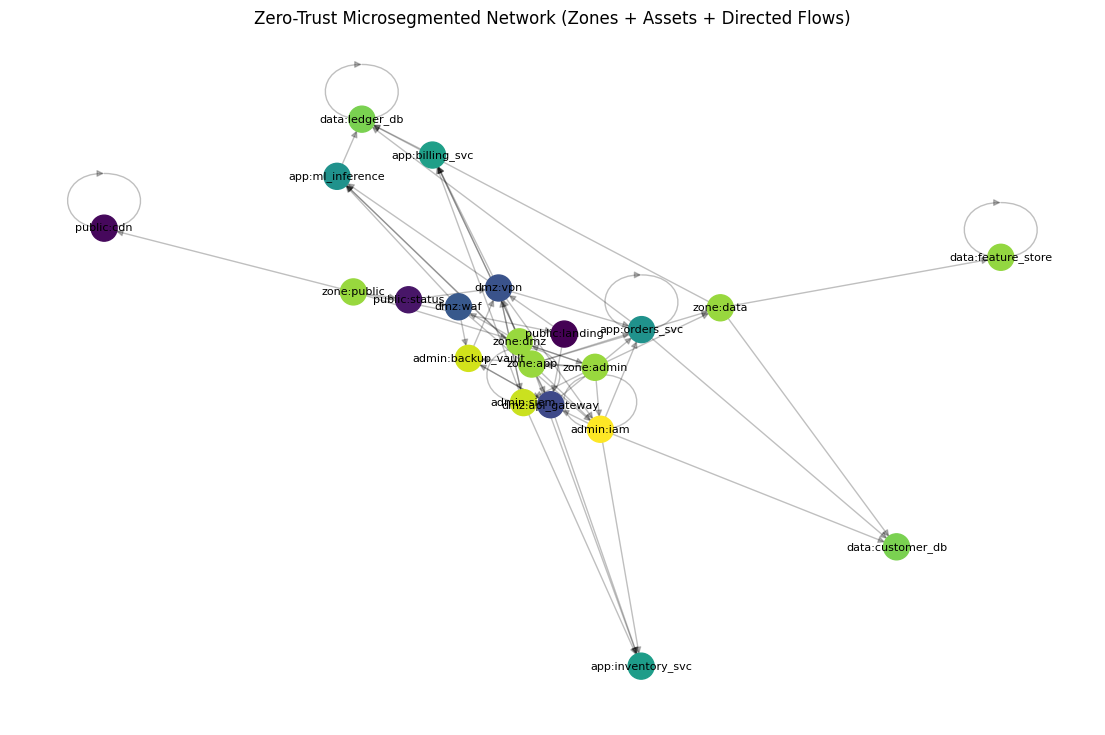

== Health ==
{'ok': True, 'policy_version': 'ztpe-v1.3'}

== Run simulation (mixture: normal + malicious flows + insider threat) ==
{
  "allowed": 9,
  "denied": 61,
  "blocked_edges_count": 42
}

== Top deny reasons ==
{
  "abac_denied": 33,
  "exfil_attempt": 7,
  "invalid_path_or_blocked": 32,
  "mfa_required_for_sensitive_zone": 10,
  "quarantined": 33,
  "rate_limited_denied": 51,
  "step_up_failed_no_mfa": 10,
  "unknown_device": 1,
  "unknown_principal": 1
}

== Principal risk snapshot (watch mallory) ==
{
  "alice": {
    "base_risk": 0.18,
    "compromise_score": 0.4,
    "quarantined": true,
    "role": "employee",
    "rolling_allows": 3,
    "rolling_denies": 6
  },
  "bob": {
    "base_risk": 0.22,
    "compromise_score": 0.22,
    "quarantined": false,
    "role": "engineer",
    "rolling_allows": 2,
    "rolling_denies": 3
  },
  "cathy": {
    "base_risk": 0.25,
    "compromise_score": 0.66,
    "quarantined": true,
    "role": "analyst",
    "rolling_allows": 0,
    "r

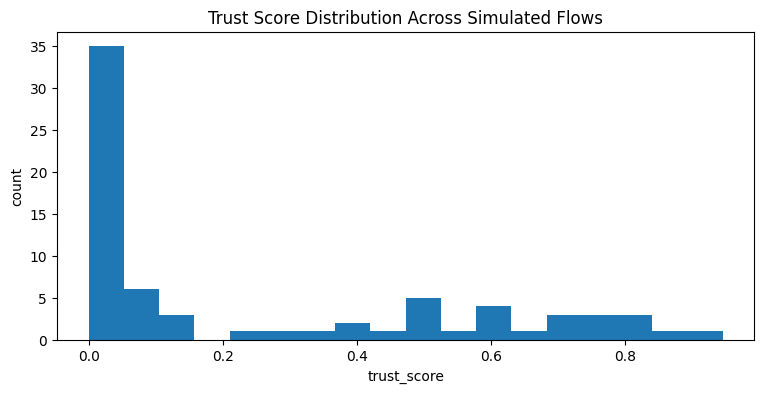


== Recent denied explanations (last 6) ==
- Decision=DENY | trust=0.047 | eve(secops) read public:cdn->dmz:api_gateway | Context: source=corp_lan, time=business_hours, geo_risk=0.15, anomaly=0.02, data_vol=0.06 | Zones: public -> dmz (dst_sensitivity=0.31) | MFA=yes | posture=0.90 | Rule hits: invalid_path_or_blocked, quarantined, rate_limited_denied | Controls: {'auto_response': 'deny_quarantine', 'rate_limit': True, 'step_up': False, 'continuous_auth': True, 'risk_signal': 'policy_violation'}
- Decision=DENY | trust=0.028 | alice(employee) admin dmz:waf->app:orders_svc | Context: source=corp_lan, time=business_hours, geo_risk=0.13, anomaly=0.17, data_vol=0.03 | Zones: dmz -> app (dst_sensitivity=0.56) | MFA=yes | posture=0.82 | Rule hits: abac_denied, quarantined, rate_limited_denied | Controls: {'auto_response': 'deny_quarantine', 'rate_limit': True, 'step_up': False, 'continuous_auth': True, 'risk_signal': 'policy_violation'}
- Decision=DENY | trust=0.001 | cathy(analyst) write ap

In [1]:
def make_app(engine: ZeroTrustPolicyEngine, world: Dict[str, Any]) -> Flask:
    app = Flask(__name__)

    @app.get("/health")
    def health():
        return jsonify({"ok": True, "policy_version": engine.policy_version})

    @app.get("/graph")
    def graph():
        nodes = [{"id": n, **engine.G.nodes[n]} for n in engine.G.nodes()]
        edges = [{"src": u, "dst": v, **engine.G.edges[u, v]} for u, v in engine.G.edges()]
        return jsonify({"nodes": nodes, "edges": edges, "blocked_edges": list(map(list, engine.blocked_edges))})

    @app.post("/request")
    def evaluate_request():
        payload = request.get_json(force=True)
        ctx = RequestContext(**payload)
        dec = engine.evaluate(ctx)
        return jsonify({"allowed": dec.allowed, "trust_score": dec.trust_score, "rule_hits": dec.rule_hits, "controls": dec.controls, "explanation": dec.explanation})

    @app.post("/simulate")
    def simulate():
        payload = request.get_json(force=True) if request.data else {}
        steps = int(payload.get("steps", 50))
        res = run_simulation(engine, world, steps=steps, seed=int(payload.get("seed", 123)))
        return jsonify({"steps": steps, "allowed": res["allowed"], "denied": res["denied"], "stats": engine.stats()})

    @app.get("/stats")
    def stats():
        return jsonify(engine.stats())

    return app


G = build_microsegmented_graph(seed=7)
engine = ZeroTrustPolicyEngine(G)
world = make_world(engine, seed=13)

draw_graph(G, title="Zero-Trust Microsegmented Network (Zones + Assets + Directed Flows)")

app = make_app(engine, world)
client = app.test_client()

print("== Health ==")
print(client.get("/health").json)

print("\n== Run simulation (mixture: normal + malicious flows + insider threat) ==")
sim_out = client.post("/simulate", json={"steps": 70, "seed": 2026}).json
print(_pretty({"allowed": sim_out["allowed"], "denied": sim_out["denied"], "blocked_edges_count": sim_out["stats"]["blocked_edges_count"]}))

print("\n== Top deny reasons ==")
print(_pretty(sim_out["stats"]["deny_reasons_top"]))

print("\n== Principal risk snapshot (watch mallory) ==")
principals = sim_out["stats"]["principals"]
focus = {k: principals[k] for k in sorted(principals.keys()) if k in ["alice","bob","cathy","dan","eve","mallory","unknown_actor"]}
print(_pretty(focus))

print("\n== Example: send a direct insider exfil request via the policy API ==")
insider_ctx = gen_request(engine, world, kind="insider_threat", seed_salt="manual-1")
insider_ctx.action = "exfiltrate"
insider_ctx.mfa = False
insider_ctx.behavior_anomaly = 0.92
insider_ctx.data_volume = 0.88
insider_ctx.geo_risk = 0.62

resp = client.post("/request", json=insider_ctx.__dict__).json
print(_pretty(resp))

print("\n== Example: a legitimate admin read with MFA from corp_lan ==")
admin_ctx = RequestContext(
    user="dan", role="admin",
    device_id="dev-dan-lt", device_type="managed_laptop", device_posture=engine.devices["dev-dan-lt"].posture,
    mfa=True, source="corp_lan",
    src_node=random.choice(world["by_zone"]["admin"]),
    dst_node=random.choice(world["by_zone"]["data"]),
    action="read",
    time_bucket="business_hours",
    geo_risk=0.08,
    behavior_anomaly=0.06,
    data_volume=0.10,
    reason="admin_operational_access"
)
resp2 = client.post("/request", json=admin_ctx.__dict__).json
print(_pretty(resp2))

print("\n== Final stats ==")
final_stats = client.get("/stats").json
print(_pretty({
    "flows_total": final_stats["flows_total"],
    "flows_allow": final_stats["flows_allow"],
    "flows_deny": final_stats["flows_deny"],
    "blocked_edges_count": final_stats["blocked_edges_count"],
    "deny_reasons_top": final_stats["deny_reasons_top"]
}))

scores = [r.decision["trust_score"] for r in engine.flow_log]
plt.figure(figsize=(9, 4))
plt.hist(scores, bins=18)
plt.title("Trust Score Distribution Across Simulated Flows")
plt.xlabel("trust_score")
plt.ylabel("count")
plt.show()

denied = [r for r in engine.flow_log if not r.decision["allowed"]]
print("\n== Recent denied explanations (last 6) ==")
for r in denied[-6:]:
    print("-", r.decision["explanation"])